In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import itertools
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
import backtrader as bt
import pyfolio as pf

### Parameters

In [3]:
ticker = 'IBM'
days=[5, 20]
return_days = 5
extreme = 3
test_date_start = datetime(2013,1,1)
test_date = test_date_start.strftime('%Y-%m-%d')
test_date_end = datetime(2017,1,1)
filename = '{}_{}_{}.h5py'.format(ticker, return_days, extreme)

In [4]:
aal = pdr.get_data_google(ticker, '2000-01-01', '2017-01-01')

In [5]:
aal.drop('Volume', axis=1, inplace=True)
aal.head()

,Open,High,Low,Close
Date,,,,
2001-02-07,113.40,117.60,112.67,116.91
2001-02-08,116.91,118.20,114.03,114.10
2001-02-09,114.03,114.99,111.00,112.00
2001-02-12,110.55,115.72,110.30,114.90
2001-02-13,114.15,117.38,113.07,113.75


In [6]:
def _set_index_column_if_necessary(data: pd.DataFrame) -> pd.DataFrame:
    if 'Date' in data.columns:
        data.set_index('Date', inplace=True)
    return data

In [7]:
aal = _set_index_column_if_necessary(aal)
cols = aal.columns
aal.head()

,Open,High,Low,Close
Date,,,,
2001-02-07,113.40,117.60,112.67,116.91
2001-02-08,116.91,118.20,114.03,114.10
2001-02-09,114.03,114.99,111.00,112.00
2001-02-12,110.55,115.72,110.30,114.90
2001-02-13,114.15,117.38,113.07,113.75


In [8]:
cols

Index(['Open', 'High', 'Low', 'Close'], dtype='object')

In [9]:
def feature(data, first_col, second_col):
    return data[first_col]/data[second_col]

In [10]:
def create_extra_columns(data, cols):
    pool = []
    for left, right in itertools.product(cols, cols):
        pair1 = left + right
        pair2 = right + left
        if left != right and pair1 not in pool and pair2 not in pool:
            aal[left + '/' + right] = feature(data, left, right)
            pool.append(pair1)

### Rolling features

In [11]:
for col, day in itertools.product(cols, days):
    aal[col + ' ' + str(day) + ' MA'] = aal[col].rolling(day).mean()
    aal[col + ' ' + str(day) + ' max'] = aal[col].rolling(day).max()
    aal[col + ' ' + str(day) + ' min'] = aal[col].rolling(day).min()
aal.dropna(inplace=True)

In [12]:
aal.columns

Index(['Open', 'High', 'Low', 'Close', 'Open 5 MA', 'Open 5 max', 'Open 5 min',
       'Open 20 MA', 'Open 20 max', 'Open 20 min', 'High 5 MA', 'High 5 max',
       'High 5 min', 'High 20 MA', 'High 20 max', 'High 20 min', 'Low 5 MA',
       'Low 5 max', 'Low 5 min', 'Low 20 MA', 'Low 20 max', 'Low 20 min',
       'Close 5 MA', 'Close 5 max', 'Close 5 min', 'Close 20 MA',
       'Close 20 max', 'Close 20 min'],
      dtype='object')

In [13]:
plain_features = list(filter(lambda col: '/' not in col, aal.columns))

In [14]:
create_extra_columns(aal, plain_features)

In [15]:
ret = 100*aal['Close'].pct_change(return_days).shift(-return_days)

In [16]:
# ret_dev = ret.rolling(10).std().fillna(1)

# ret_scaled = ret/ret_dev
# ret_scaled.head()

In [17]:
features_to_drop = list(filter(lambda col: '/' not in col, aal.columns))
aal.drop(features_to_drop, axis=1, inplace=True)

aal['Return'] = ret # ret_scaled
aal.head(10)

,Open/High,Open/Low,Open/Close,Open/Open 5 MA,Open/Open 5 max,Open/Open 5 min,Open/Open 20 MA,Open/Open 20 max,Open/Open 20 min,Open/High 5 MA,...,Close 5 max/Close 20 MA,Close 5 max/Close 20 max,Close 5 max/Close 20 min,Close 5 min/Close 20 MA,Close 5 min/Close 20 max,Close 5 min/Close 20 min,Close 20 MA/Close 20 max,Close 20 MA/Close 20 min,Close 20 max/Close 20 min,Return
Date,,,,,,,,,,,,,,,,,,,,,
2001-03-07,0.992610,1.016941,0.999070,1.033551,1.000000,1.082075,0.983209,0.919083,1.082075,1.001771,...,0.984417,0.919938,1.076577,0.936363,0.875032,1.024024,0.934501,1.093619,1.170270,-11.706183
2001-03-08,0.998416,1.017083,1.006575,1.015483,0.997394,1.042408,0.983450,0.916688,1.079255,0.997413,...,0.989143,0.920962,1.076577,0.940858,0.876006,1.024024,0.931071,1.088393,1.168969,-10.247018
2001-03-09,0.999905,1.072523,1.057508,0.993039,0.977199,1.021301,0.968831,0.898973,1.057402,0.982043,...,0.995926,0.920962,1.083191,0.919437,0.850231,1.000000,0.924730,1.087622,1.176151,-9.255716
2001-03-12,0.994919,1.030309,1.025238,0.934571,0.911121,1.000000,0.910092,0.838185,1.000000,0.928138,...,1.003597,0.920962,1.126296,0.891060,0.817691,1.000000,0.917661,1.122259,1.222955,-3.026495
2001-03-13,0.966071,1.009554,0.966562,0.927588,0.885063,1.000000,0.890458,0.814212,1.000000,0.918947,...,1.011388,0.920962,1.126296,0.897977,0.817691,1.000000,0.910593,1.113614,1.222955,-10.255107
2001-03-14,0.971689,1.029569,1.012005,0.958565,0.896706,1.010515,0.907490,0.822774,1.010515,0.945699,...,1.010157,0.911714,1.121209,0.900953,0.813153,1.000000,0.902548,1.109936,1.229781,-6.192081
2001-03-15,0.980893,1.010952,1.004604,0.979392,0.914286,1.009464,0.914207,0.821918,1.009464,0.962657,...,0.950849,0.850231,1.045598,0.909383,0.813153,1.000000,0.894181,1.099647,1.229781,-6.760151
2001-03-16,0.999574,1.064626,1.042175,0.980167,0.959142,1.000000,0.904067,0.819729,1.000000,0.962978,...,0.954423,0.855565,1.092009,0.874006,0.783478,1.000000,0.896422,1.144156,1.276360,3.973363
2001-03-19,0.980603,1.020179,0.982721,0.963779,0.946930,1.000000,0.886192,0.794413,1.000000,0.944081,...,0.964906,0.882422,1.092009,0.883606,0.808072,1.000000,0.914516,1.131726,1.237514,3.023758


In [18]:
len(aal.columns)

379

In [19]:
list(aal.columns)[:5]

['Open/High', 'Open/Low', 'Open/Close', 'Open/Open 5 MA', 'Open/Open 5 max']

# X/y spit

In [20]:
aal.dropna(inplace=True)
aal.replace([np.inf, -np.inf], 1, inplace=True)
X_data = aal.drop('Return', axis=1)
y_data = aal['Return']

In [21]:
X_data.head(2)

,Open/High,Open/Low,Open/Close,Open/Open 5 MA,Open/Open 5 max,Open/Open 5 min,Open/Open 20 MA,Open/Open 20 max,Open/Open 20 min,Open/High 5 MA,...,Close 5 max/Close 5 min,Close 5 max/Close 20 MA,Close 5 max/Close 20 max,Close 5 max/Close 20 min,Close 5 min/Close 20 MA,Close 5 min/Close 20 max,Close 5 min/Close 20 min,Close 20 MA/Close 20 max,Close 20 MA/Close 20 min,Close 20 max/Close 20 min
Date,,,,,,,,,,,,,,,,,,,,,
2001-03-07,0.992610,1.016941,0.999070,1.033551,1.000000,1.082075,0.983209,0.919083,1.082075,1.001771,...,1.05132,0.984417,0.919938,1.076577,0.936363,0.875032,1.024024,0.934501,1.093619,1.170270
2001-03-08,0.998416,1.017083,1.006575,1.015483,0.997394,1.042408,0.983450,0.916688,1.079255,0.997413,...,1.05132,0.989143,0.920962,1.076577,0.940858,0.876006,1.024024,0.931071,1.088393,1.168969


In [22]:
y_data.head(2)

Date
2001-03-07   -11.706183
2001-03-08   -10.247018
Name: Return, dtype: float64

In [23]:
def series_to_binarized_columns(y):
    pos = y > extreme
    neg = y < -extreme
    meds = (y > -extreme) & (y < extreme)
    y = np.array([neg, meds, pos]).T
    return y

In [24]:
X_train = X_data[:test_date]
X_test = X_data[test_date:]
y_train = y_data[:test_date]
y_test = y_data[test_date:]

In [25]:
y_train = series_to_binarized_columns(y_train)
y_test = series_to_binarized_columns(y_test)

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [27]:
X_test_df = X_test.copy()
X_test = scaler.transform(X_test)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns, index=X_test_df.index)

In [28]:
X_test_df.head(1)

,Open/High,Open/Low,Open/Close,Open/Open 5 MA,Open/Open 5 max,Open/Open 5 min,Open/Open 20 MA,Open/Open 20 max,Open/Open 20 min,Open/High 5 MA,...,Close 5 max/Close 5 min,Close 5 max/Close 20 MA,Close 5 max/Close 20 max,Close 5 max/Close 20 min,Close 5 min/Close 20 MA,Close 5 min/Close 20 max,Close 5 min/Close 20 min,Close 20 MA/Close 20 max,Close 20 MA/Close 20 min,Close 20 max/Close 20 min
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,-0.172606,-0.745825,-0.828964,0.721171,0.717774,0.444074,0.214262,0.647761,-0.40018,0.818956,...,0.11004,0.098208,0.635829,-0.441938,-0.003936,0.398478,-0.58881,0.743127,-0.725144,-0.750548


# KERAS

In [29]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization, LSTM
from keras.optimizers import Adam, RMSprop
from keras.models import load_model

Using TensorFlow backend.


In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

In [31]:
def expand(X, axis=1):
    return np.expand_dims(X, axis=axis)

In [32]:
temp_y = np.argmax(y_train, axis=1)
cw = class_weight.compute_class_weight('balanced', np.unique(temp_y), temp_y)
cw

array([ 2.60104987,  0.46222015,  2.21205357])

In [33]:
input_shape = (1, 1, X_train.shape[1])
input_shape

(1, 1, 378)

In [34]:
def build_and_run():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, batch_input_shape=input_shape, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False, stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(3, kernel_initializer='glorot_uniform'))
    model.add(Activation('softmax'))

    model.compile(optimizer=Adam(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    for i in range(30):
        print(f'Iteration {i}')
        model.fit(expand(X_train), y_train, class_weight=cw, batch_size=1, epochs=5, shuffle=False, verbose=2)
        model.reset_states()
    model.save(filename)
    return model

In [35]:
#model.fit(expand(X_train), y_train, class_weight=cw, batch_size=1, epochs=100, shuffle=False, verbose=2) # , validation_data=(expand(X_test), y_test)

In [36]:
try:
    model = load_model(filename)
except:
    model = build_and_run()

Iteration 0
Epoch 1/5
 - 14s - loss: 0.7830 - acc: 0.6942
Epoch 2/5
 - 11s - loss: 0.7509 - acc: 0.7144
Epoch 3/5
 - 11s - loss: 0.7485 - acc: 0.7205
Epoch 4/5
 - 12s - loss: 0.7422 - acc: 0.7228
Epoch 5/5
 - 12s - loss: 0.7398 - acc: 0.7249
Iteration 1
Epoch 1/5
 - 12s - loss: 0.7307 - acc: 0.7252
Epoch 2/5
 - 12s - loss: 0.7364 - acc: 0.7289
Epoch 3/5
 - 12s - loss: 0.7231 - acc: 0.7275
Epoch 4/5
 - 12s - loss: 0.7246 - acc: 0.7279
Epoch 5/5
 - 12s - loss: 0.7183 - acc: 0.7302
Iteration 2
Epoch 1/5
 - 12s - loss: 0.7137 - acc: 0.7272
Epoch 2/5
 - 12s - loss: 0.7038 - acc: 0.7333
Epoch 3/5
 - 12s - loss: 0.6970 - acc: 0.7353
Epoch 4/5
 - 13s - loss: 0.6902 - acc: 0.7393
Epoch 5/5
 - 12s - loss: 0.6816 - acc: 0.7407
Iteration 3
Epoch 1/5
 - 12s - loss: 0.6922 - acc: 0.7393
Epoch 2/5
 - 12s - loss: 0.6832 - acc: 0.7370
Epoch 3/5
 - 13s - loss: 0.6704 - acc: 0.7477
Epoch 4/5
 - 13s - loss: 0.6767 - acc: 0.7417
Epoch 5/5
 - 13s - loss: 0.6779 - acc: 0.7457
Iteration 4
Epoch 1/5
 - 13s - l

In [37]:
class ModelEvaluator:
    def __init__(self,
                 model):
        self.model = model

    def evaluate(self, X, y, ret):
        all_returns = []
        for c in [0.34 + x/50 for x in range(35)]:
            print('=================')
            print(f'Certainty is {c}')
            returns = self.calculate_returns(X, y, ret, c)
            cont = self.print_returns_distribution(returns)
            if not cont:
                break

    def calculate_returns(self, X, y, ret, certainty):
        predicted = self.model.predict(expand(X), batch_size=1)
        real_ups = y[:, 2]
        real_downs = y[:, 0]
        predicted_ups = (predicted[:, 2] > certainty)# & (np.argmax(predicted, axis=1) == 2)
        predicted_downs = (predicted[:, 0] > certainty)# & (np.argmax(predicted, axis=1) == 0)
        returns = np.append(ret[predicted_ups],
                            (-1 * ret[predicted_downs]))

        print('Real ups count: {}'.format(pd.value_counts(real_ups[predicted_ups])))
        print('Real downs count: {}'.format(pd.value_counts(real_downs[predicted_downs])))
        return returns

    def print_returns_distribution(self, returns):
        lose = np.sum(returns[returns < 0])
        win = np.sum(returns[returns > 0])
        if lose == 0 and win == 0:
            return False
        print('Negative returns:', str(lose))
        print('Positive returns:', str(win))
        print('Pos/Neg ratio:', str(win / (lose * -1)))
        print('Sum of returns:', str(np.sum(returns)))
        return True

In [38]:
evaluator = ModelEvaluator(model)
evaluator.evaluate(X_test, y_test, y_data[test_date:]) # [:988]

Certainty is 0.34
Real ups count: False    44
True      9
dtype: int64
Real downs count: False    26
True      4
dtype: int64
Negative returns: -61.891663372
Positive returns: 117.332685275
Pos/Neg ratio: 1.89577527703
Sum of returns: 55.441021903
Certainty is 0.36000000000000004
Real ups count: False    34
True      9
dtype: int64
Real downs count: False    25
True      3
dtype: int64
Negative returns: -43.7089704457
Positive returns: 110.824570345
Pos/Neg ratio: 2.53551088518
Sum of returns: 67.1155998997
Certainty is 0.38
Real ups count: False    32
True      9
dtype: int64
Real downs count: False    23
True      3
dtype: int64
Negative returns: -42.5842260695
Positive returns: 105.933121953
Pos/Neg ratio: 2.48761411749
Sum of returns: 63.3488958835
Certainty is 0.4
Real ups count: False    31
True      9
dtype: int64
Real downs count: False    20
True      3
dtype: int64
Negative returns: -38.1768309935
Positive returns: 105.831270293
Pos/Neg ratio: 2.77213345212
Sum of returns: 67

# Backtest

In [48]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.certainty = 0.4
        self.dataclose = self.datas[0].close
        self.orders = {}
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
    def entries_to_remove(entries, the_dict):
        for key in entries:
            if key in the_dict:
                del the_dict[key]

    def next(self):
        if not self.position:
            try:
                today = self.datas[0].datetime.date(0).isoformat()
                data_row = X_test_df.loc[today]
                prediction = model.predict(expand(expand(data_row,0),0))[0]
                def log_candles():
                    self.log('Current Open: {}, Close: {}'.format(self.data0.open[0],self.data0.close[0]))
                    self.log('Next Open: {}, Close: {}'.format(self.data0.open[1],self.data0.close[1]))
                
                if prediction[2] > self.certainty:
                    self.log(f'======> Predict long for {today}')
                    log_candles()
                    self.orders[len(self)] = self.buy(exectype=bt.Order.Market)
                elif prediction[0] > self.certainty:
                    self.log(f'======> Predict short for {today}')
                    log_candles()
                    self.orders[len(self)] = self.sell(exectype=bt.Order.Market)
            except Exception as e:
                self.log(e)
        
        old_entries = []
        for days, order_on_days in self.orders.items():
            if len(self) >= days + return_days:
                old_entries.append(days)
                if order_on_days.isbuy():
                    self.log('closing the long position')
                    self.sell(exectype=bt.Order.Market)
                else:
                    self.log('closing the short position')
                    self.buy(exectype=bt.Order.Market) # exectype=bt.Order.Close
        TestStrategy.entries_to_remove(old_entries, self.orders)

In [49]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)

data = bt.feeds.YahooFinanceData(
    dataname=ticker,
    fromdate=test_date_start,
    todate=test_date_end,
    reverse=False)

cerebro.adddata(data)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.broker.set_coc(True)
cerebro.addsizer(bt.sizers.PercentSizer, percents=50)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

Starting Portfolio Value: 100000.00
2013-01-03, ======> Predict short for 2013-01-03
2013-01-03, Current Open: 195.67, Close: 167.94
2013-01-03, Next Open: 194.19, Close: 166.84
2013-01-04, SELL EXECUTED, 167.94
2013-01-10, closing the short position
2013-01-11, BUY EXECUTED, 165.88
2013-03-05, ======> Predict long for 2013-03-05
2013-03-05, Current Open: 205.86, Close: 178.37
2013-03-05, Next Open: 207.03, Close: 179.97
2013-03-06, BUY EXECUTED, 178.37
2013-03-12, closing the long position
2013-03-13, SELL EXECUTED, 181.84
2013-06-04, ======> Predict long for 2013-06-04
2013-06-04, Current Open: 208.6, Close: 178.91
2013-06-04, Next Open: 205.16, Close: 175.92
2013-06-05, BUY EXECUTED, 178.91
2013-06-11, closing the long position
2013-06-12, SELL EXECUTED, 176.99
2013-06-21, ======> Predict long for 2013-06-21
2013-06-21, Current Open: 198.5, Close: 169.6
2013-06-21, Next Open: 193.99, Close: 167.93
2013-06-24, BUY EXECUTED, 169.60
2013-06-28, closing the long position
2013-07-01, SEL

Entire data start date: 2013-01-02
Entire data end date: 2016-12-30
Backtest months: 48


,Backtest
Annual return,2.2%
Cumulative returns,9.0%
Annual volatility,3.9%
Sharpe ratio,0.57
Calmar ratio,0.33
Stability,0.83
Max drawdown,-6.7%
Omega ratio,1.27
Sortino ratio,0.92
Skew,1.87


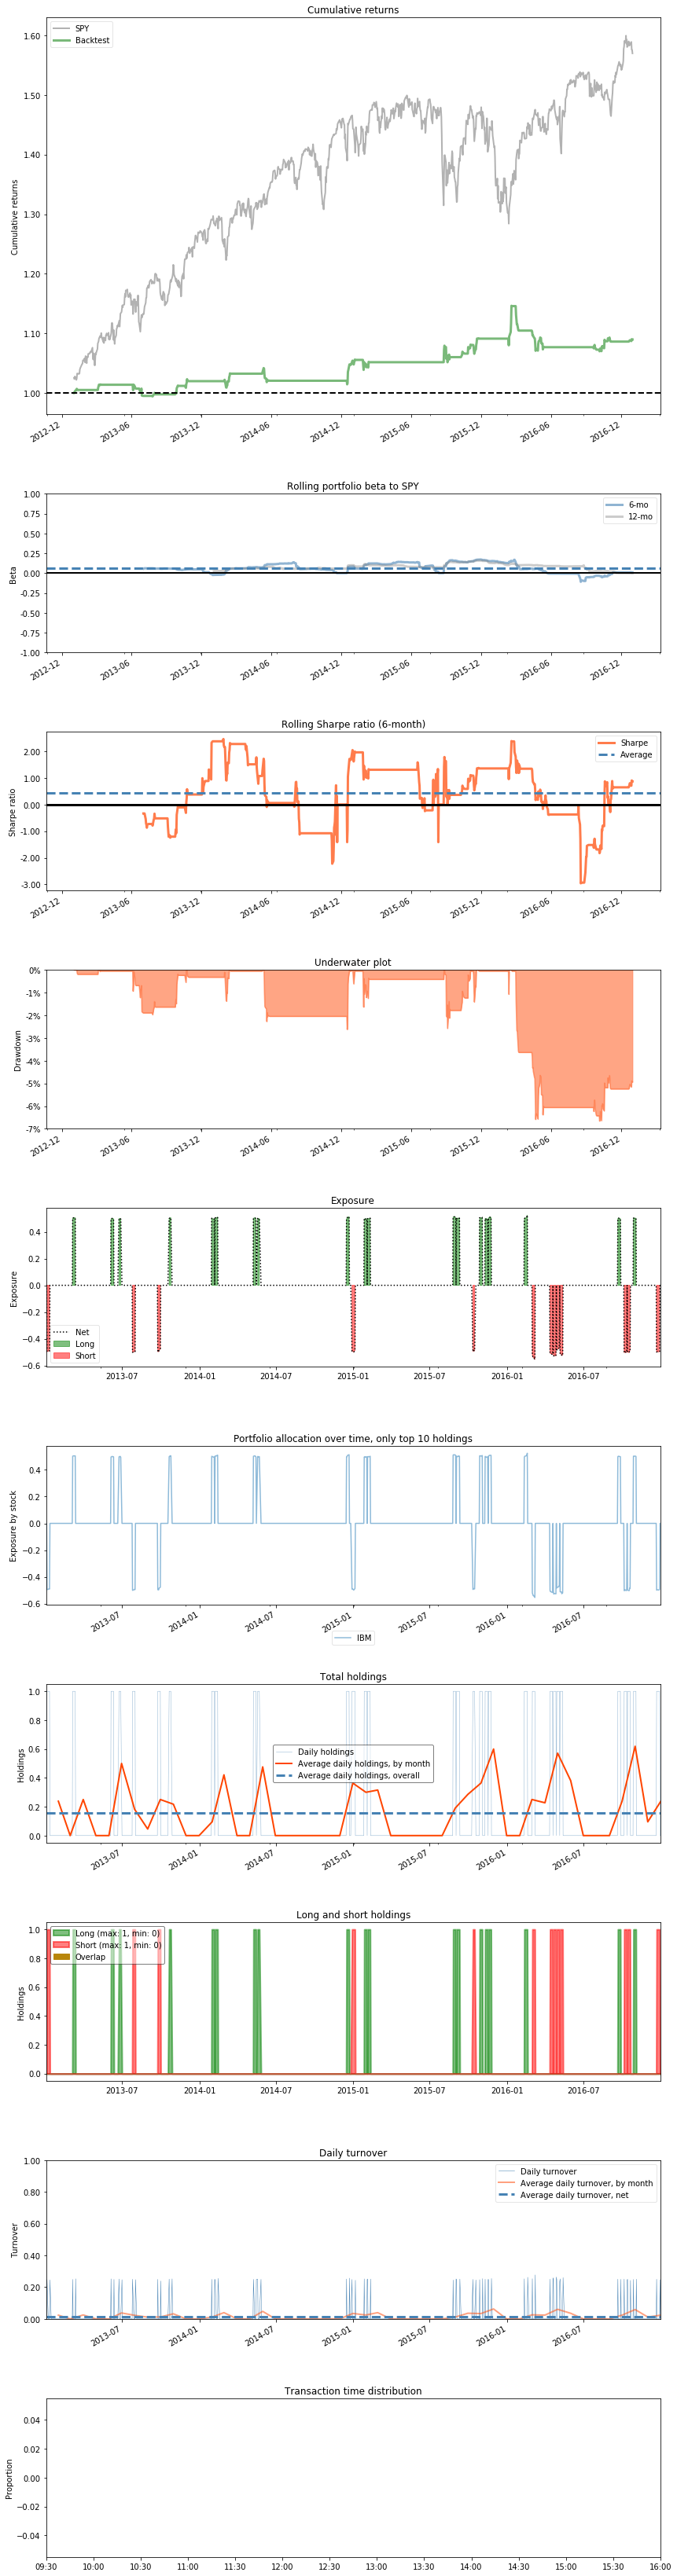

In [50]:
pf.create_simple_tear_sheet(returns=returns, 
                          positions=positions, 
                          transactions=transactions)